# Run LAMMPS with atomman

Tools for setting up and running LAMMPS calculations are available in the atomman.lammps submodule

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np

import atomman as am
import atomman.unitconvert as uc
import atomman.lammps as lmp

## 1. Specify *your* LAMMPS and mpi_commands

In [3]:
lammps_command = 'lmp'
#mpi_command = None
mpi_command = 'mpiexec -n 2'

## 2. Load a potential, unit cell, and build a system

In [4]:
potential = am.load_lammps_potential('2004--Zhou-X-W--Au--LAMMPS--ipr2', getfiles=True, pot_dir_style='id')

ucell = am.load('crystal', potential=potential, family='A1--Cu--fcc', symbols='Au')
print(ucell)

{'detail': 'Authentication credentials were not provided.'}
avect =  [ 4.080,  0.000,  0.000]
bvect =  [ 0.000,  4.080,  0.000]
cvect =  [ 0.000,  0.000,  4.080]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Au',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.040 |   2.040
      2 |       1 |   2.040 |   0.000 |   2.040
      3 |       1 |   2.040 |   2.040 |   0.000


Now, we're going to make a 5x5x5 supercell and randomly delete 2 atoms just for fun.  The relatively small size is simply to make the simulation fast...

In [5]:
system = ucell.supersize(5, 5, 5)

In [6]:
# Random shuffle atom ids
allids = [i for i in range(system.natoms)]
random.shuffle(allids)

# Slice system with atoms_ix using all ids except for the first 2
system = system.atoms_ix[allids[2:]]
print(system.natoms)

498


## 3. Define a template LAMMPS script

This script is designed to evaluate mean squared displacements.  All values in "\<\>" are variables that are to be filled in from Python.

In [7]:
template = """
# LAMMPS input script for dynamic msd computation

<atomman_system_pair_info>

# Assign simulation parameter values
variable temperature equal <temperature>
variable randomseed equal <randomseed>
variable thermosteps equal <thermosteps>
variable timestep equal <timestep>
variable dumpsteps equal <dumpsteps>
variable runsteps equal <runsteps>
variable twotemp equal 2*${temperature}
variable damptemp equal 100*${timestep}

# Specify property computes
compute peatom all pe/atom
compute msd all msd com yes

# Define thermo data
thermo ${thermosteps}
thermo_style custom step temp pe ke etotal pxx pyy pzz c_msd[1] c_msd[2] c_msd[3] c_msd[4]
thermo_modify format float %.13e

# Specify timestep
timestep ${timestep}

# Define dump file contents and frequency
dump dumpit all custom ${dumpsteps} *.dump id type x y z c_peatom
dump_modify dumpit format float %.13e

# Create velocities and equilibrate system using nvt
velocity all create ${twotemp} ${randomseed}
fix nvt all nvt temp ${temperature} ${temperature} ${damptemp}
run ${runsteps}

"""

## 4. Build LAMMPS script by filling in the template

### 4.1. Save the system to a data file

In [8]:
data_file = 'init.dat'
system_pair_info = system.dump('atom_data', f=data_file, potential=potential)

### 4.2. Build the LAMMPS script

Create a dict specifying what values to fill in for the \<\> terms in the template script

In [9]:
lammps_variables = {}
lammps_variables['atomman_system_pair_info'] = system_pair_info
lammps_variables['temperature'] = 1200
lammps_variables['randomseed'] = lmp.newseed()              # generates a random LAMMPS-compatible random seed
lammps_variables['thermosteps'] = 100
lammps_variables['timestep'] = lmp.style.timestep('metal')  # selects the default timestep to use for a unit style
lammps_variables['dumpsteps'] = 10000
lammps_variables['runsteps'] = 20000

Fill in the template to build the LAMMPS script.  

In [10]:
# Function parameters: template, replacement dict, before and after delimiters for template variables
script = am.tools.filltemplate(template, lammps_variables, '<', '>')
print(script)


# LAMMPS input script for dynamic msd computation

units metal
atom_style atomic

boundary p p p
read_data init.dat

print "Potential 2004--Zhou-X-W--Au--LAMMPS--ipr2 listed in the NIST Interatomic Potentials Repository:"
print "https://www.ctcms.nist.gov/potentials/entry/2004--Zhou-X-W-Johnson-R-A-Wadley-H-N-G--Au/2004--Zhou-X-W--Au--LAMMPS--ipr2.html"
print "Publication(s) related to the potential:"
print "https://doi.org/10.1103/physrevb.69.144113"
print "Parameter file(s) can be downloaded at:"
print "https://www.ctcms.nist.gov/potentials/Download/2004--Zhou-X-W-Johnson-R-A-Wadley-H-N-G--Au/4/Au_Zhou04.eam.alloy"

pair_style eam/alloy 
pair_coeff * * Au_Zhou04.eam.alloy Au

mass 1 196.97



# Assign simulation parameter values
variable temperature equal 1200
variable randomseed equal 291971790
variable thermosteps equal 100
variable timestep equal 0.001
variable dumpsteps equal 10000
variable runsteps equal 20000
variable twotemp equal 2*${temperature}
variable damptemp equal 100*

## 5. Run LAMMPS and explore results

### 5.1. Run LAMMPS

Run with atomman.lammps.run().  If it finishes successfully, it will return a Log object.  If if crashes, it should throw a LAMMPSError.

In [11]:
log = lmp.run(lammps_command, script=script, mpi_command=mpi_command)

In [11]:
badscript = """
units metal
bad_command  does not exist
"""
lmp.run(lammps_command, script=badscript)

LammpsError: Unknown command: bad_command  does not exist (src/input.cpp:314)
Last input line: bad_command does not exist


### 5.2. Explore log outputs

The returned log object contains a list of simulations.  Each simulation has two tables of data: "performance" which collects the LAMMPS computational time information, and "thermo" which collects that simulation's thermo data.

Also, you can use the Log objects to read in log.lammps files.

In [12]:
print(len(log.simulations))

1


In [13]:
sim = log.simulations[0]
sim.performance

,min time,avg time,max time,%varavg,%total
Section,,,,,
Pair,19.618000,19.646000,19.674000,0.6,76.36
Neigh,0.122870,0.123300,0.123740,0.1,0.48
Comm,5.513000,5.538600,5.564300,1.1,21.53
Output,0.015199,0.018771,0.022342,2.6,0.07
Modify,0.231560,0.232950,0.234330,0.3,0.91
Other,0.000000,0.169400,0.000000,0.0,0.66


In [14]:
sim.performance['max time'].sum()

np.float64(25.618712)

In [15]:
sim.thermo

,Step,Temp,PotEng,KinEng,TotEng,Pxx,Pyy,Pzz,c_msd[1],c_msd[2],c_msd[3],c_msd[4]
0,0,2400.000000,-1954.988838,154.181501,-1800.807337,17093.398683,16911.670679,16859.383504,2.839899e-29,3.155444e-30,2.019484e-28,2.335028e-28
1,100,786.865087,-1863.396484,50.550017,-1812.846467,84295.558780,93887.658596,92276.142909,4.237694e-02,3.847777e-02,3.951777e-02,1.203725e-01
2,200,1076.232254,-1868.422284,69.139627,-1799.282657,84174.612970,90101.345623,88547.127970,5.940216e-02,4.904417e-02,4.958503e-02,1.580314e-01
3,300,1215.853885,-1869.236586,78.109240,-1791.127345,87221.314965,88535.295392,90031.786856,5.408282e-02,6.192638e-02,4.698867e-02,1.629979e-01
4,400,1288.923140,-1874.803596,82.803377,-1792.000219,84834.856418,83976.061229,86467.846737,5.446230e-02,6.318542e-02,4.349591e-02,1.611436e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
196,19600,1303.497993,-1881.921357,83.739699,-1798.181658,76577.641685,77991.002560,78282.367892,4.558363e-02,6.468604e-02,5.075854e-02,1.610282e-01
197,19700,1212.631807,-1876.659378,77.902247,-1798.757132,80300.399073,81471.214669,82781.305235,5.011097e-02,6.416433e-02,5.450355e-02,1.687789e-01
198,19800,1211.258260,-1881.800983,77.814007,-1803.986976,78449.376395,75275.420562,80529.689748,4.774340e-02,6.530637e-02,5.112554e-02,1.641753e-01
199,19900,1084.063203,-1879.644316,69.642705,-1810.001611,80247.409737,75915.361526,79763.226771,4.679579e-02,7.237655e-02,5.555595e-02,1.747283e-01


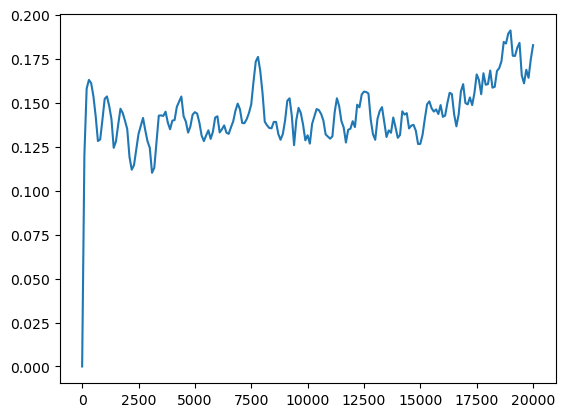

In [16]:
plt.plot(sim.thermo.Step, sim.thermo['c_msd[4]'])

### 5.3. Load dump files

You can use atomman.load to read in any of the dump files to do any further per-atom processing of the results using atomman.

In [18]:
final = am.load('atom_dump', '20000.dump')
print(final.atoms_prop())

['atype', 'pos', 'atom_id', 'c_peatom']


**File cleanup**

In [19]:
from pathlib import Path
import shutil

for potdir in Path().glob('19*--ipr*'):
    if potdir.is_dir():
        shutil.rmtree(potdir)
for potdir in Path().glob('20*--ipr*'):
    if potdir.is_dir():
        shutil.rmtree(potdir)
for fname in Path().glob('*.dump'):
    fname.unlink()
if Path('log.lammps').exists():
    Path('log.lammps').unlink()
if Path('init.dat').exists():
    Path('init.dat').unlink()